In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys

In [2]:
tumor = []
healthy = []
for f in glob.iglob('./data/lungcancer_dataset/CancerCases/*.jpg'):
#for f in glob.iglob(r"C:\Users\User\Desktop\tumor\Training\glioma\*.jpg"):
    
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

#for f in glob.iglob(r"C:\Users\User\Desktop\tumor\Training\notumor\*.jpg"):
for f in glob.iglob('./data/lungcancer_dataset/NormalCases/*.jpg'):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128)) 
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [3]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [4]:
healthy.shape

(416, 128, 128, 3)

In [5]:
tumor.shape

(681, 128, 128, 3)

In [6]:
np.random.choice(10, 5, replace=False)

array([2, 6, 1, 5, 8])

In [7]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
        
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])
        

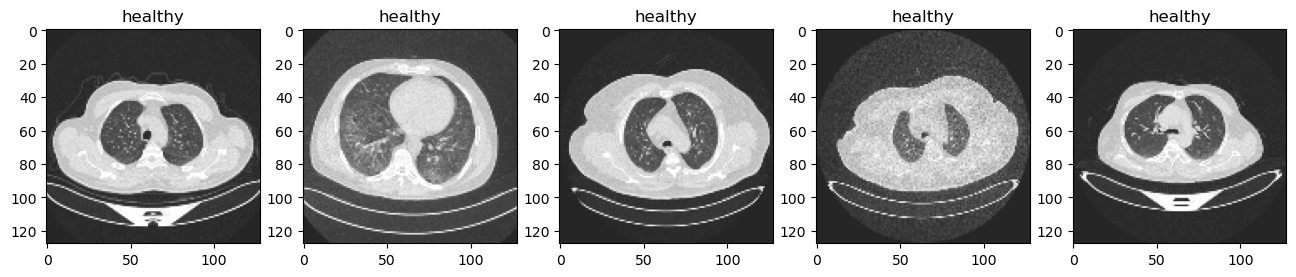

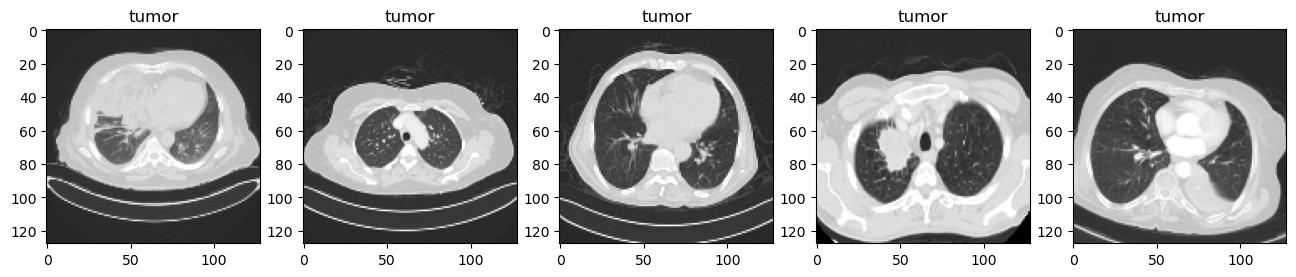

In [8]:
plot_random(healthy, tumor, num=5)

In [9]:
class Dataset(object):
    

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [10]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
       
        for f in glob.iglob('./data/lungcancer_dataset/CancerCases/*.jpg'):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) 
            tumor.append(img)

        for f in glob.iglob('./data/lungcancer_dataset/NormalCases/*.jpg'):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

      
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [11]:
mri_dataset = MRI()
mri_dataset.normalize()

In [12]:
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(mri_dataset.images, mri_dataset.labels, test_size=0.2, random_state=42)


train_dataset = MRI()
train_dataset.images = X_train
train_dataset.labels = y_train

test_dataset = MRI()
test_dataset.images = X_test
test_dataset.labels = y_test


train_dataloader = DataLoader(train_dataset, shuffle=True)
test_dataloader = DataLoader(test_dataset, shuffle=False)

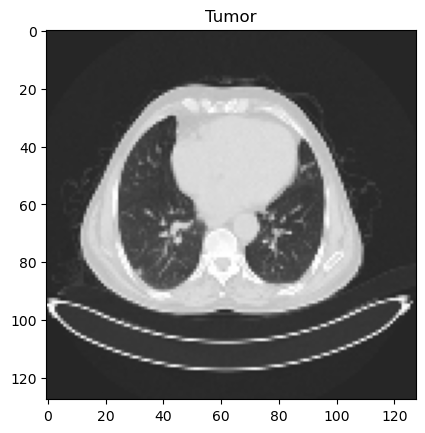

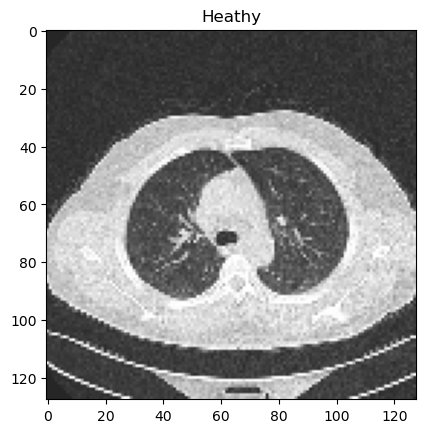

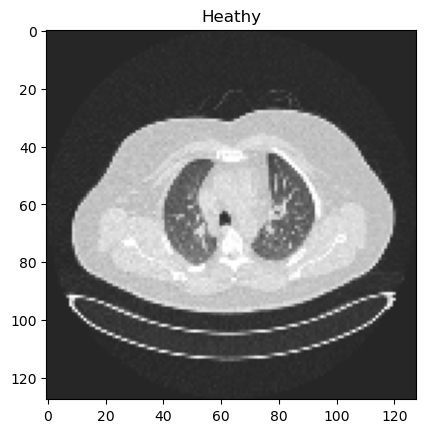

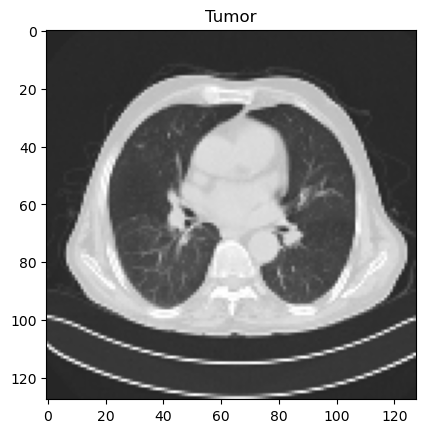

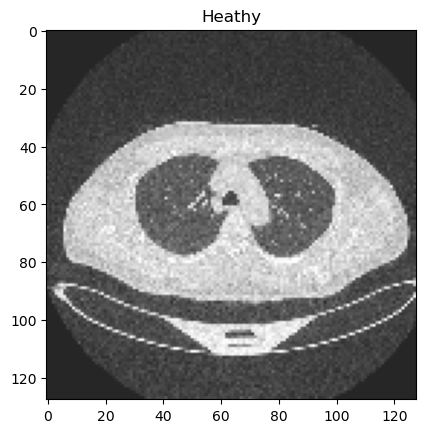

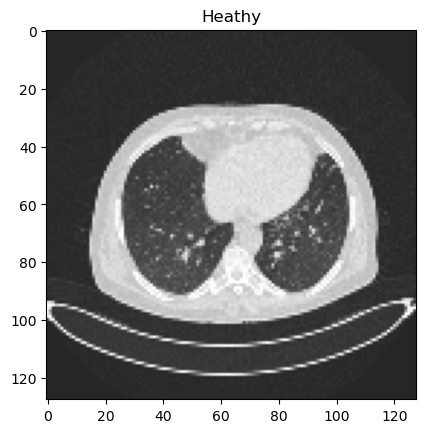

In [13]:
names={0:'Heathy', 1:'Tumor'}
train_dataloader = DataLoader(train_dataset, shuffle=True)
for i, sample in enumerate(train_dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x
            

In [15]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


cpu_tensor = torch.rand(10).to(device)

gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.6178, 0.6135, 0.0656, 0.1288, 0.1956, 0.1855, 0.2959, 0.5508, 0.7119,
        0.8200]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.6178, 0.6135, 0.0656, 0.1288, 0.1956, 0.1855, 0.2959, 0.5508, 0.7119,
        0.8200]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.3817, 0.3764, 0.0043, 0.0166, 0.0382, 0.0344, 0.0876, 0.3034, 0.5068,
        0.6725])


In [16]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

In [17]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [18]:
import numpy as np
import torch


model.eval()
outputs = []
y_true = []

with torch.no_grad():
    for D in train_dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        # Ensure outputs are at least 1-D
        output_array = y_hat.cpu().detach().numpy()
        label_array = label.cpu().detach().numpy()

        # If output or label are zero-dimensional, make them 1-D
        if output_array.ndim == 0:
            output_array = np.expand_dims(output_array, axis=0)
        if label_array.ndim == 0:
            label_array = np.expand_dims(label_array, axis=0)

        outputs.append(output_array)
        y_true.append(label_array)

    outputs = np.concatenate(outputs, axis=0).squeeze()
    y_true = np.concatenate(y_true, axis=0).squeeze()


In [19]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [20]:
accuracy_score(y_true, threshold(outputs))

0.5843208751139471

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

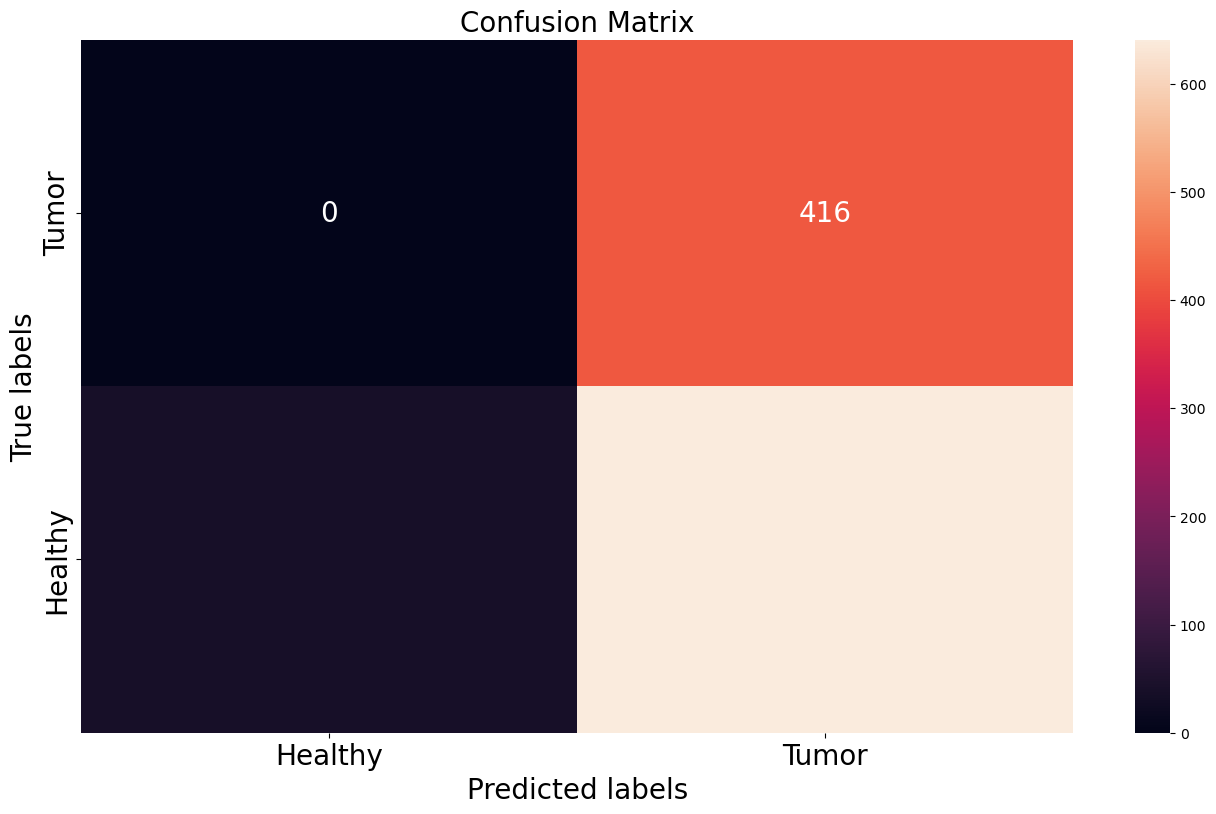

In [21]:

import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})


ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

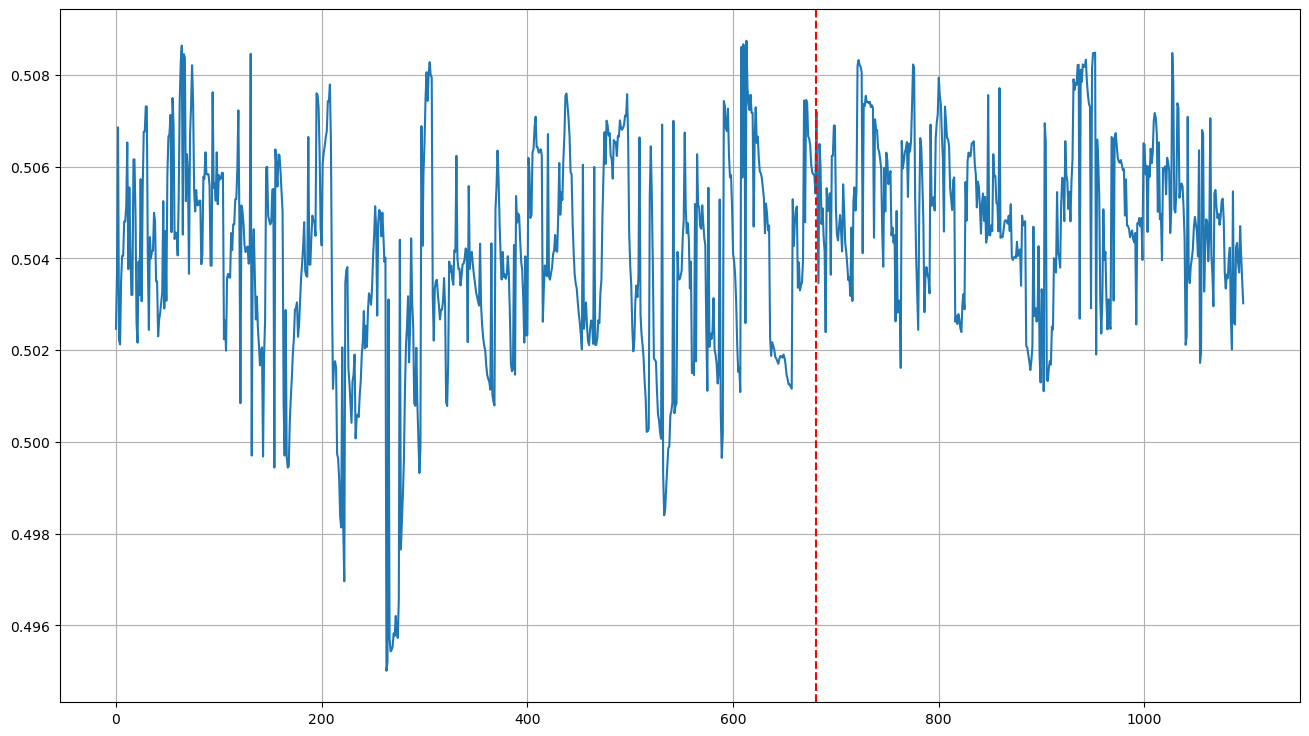

In [22]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [23]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [24]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_


scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)

for epoch in range(1, EPOCH):
    losses = []
    for D in train_dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
       
        error = nn.BCELoss() 
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        
       
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        losses.append(loss.item())
        
    
    scheduler.step(np.mean(losses))
        
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))


C:\Users\User\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Train Epoch: 10	Loss: 0.568192
Train Epoch: 20	Loss: 0.468237
Train Epoch: 30	Loss: 0.328699
Train Epoch: 40	Loss: 0.241306
Train Epoch: 50	Loss: 0.169215
Train Epoch: 60	Loss: 0.113484
Train Epoch: 70	Loss: 0.072610
Train Epoch: 80	Loss: 0.058618
Train Epoch: 90	Loss: 0.036547
Train Epoch: 100	Loss: 0.028222
Train Epoch: 110	Loss: 0.018667
Train Epoch: 120	Loss: 0.015784
Train Epoch: 130	Loss: 0.011239
Train Epoch: 140	Loss: 0.010772
Train Epoch: 150	Loss: 0.008024
Train Epoch: 160	Loss: 0.006972
Train Epoch: 170	Loss: 0.006881
Train Epoch: 180	Loss: 0.006867
Train Epoch: 190	Loss: 0.006868
Train Epoch: 200	Loss: 0.006869
Train Epoch: 210	Loss: 0.006872
Train Epoch: 220	Loss: 0.006862
Train Epoch: 230	Loss: 0.006887
Train Epoch: 240	Loss: 0.006857


KeyboardInterrupt: 

In [25]:
model.eval()
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in train_dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [26]:
accuracy_score(y_true, threshold(outputs))

0.9981768459434822

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

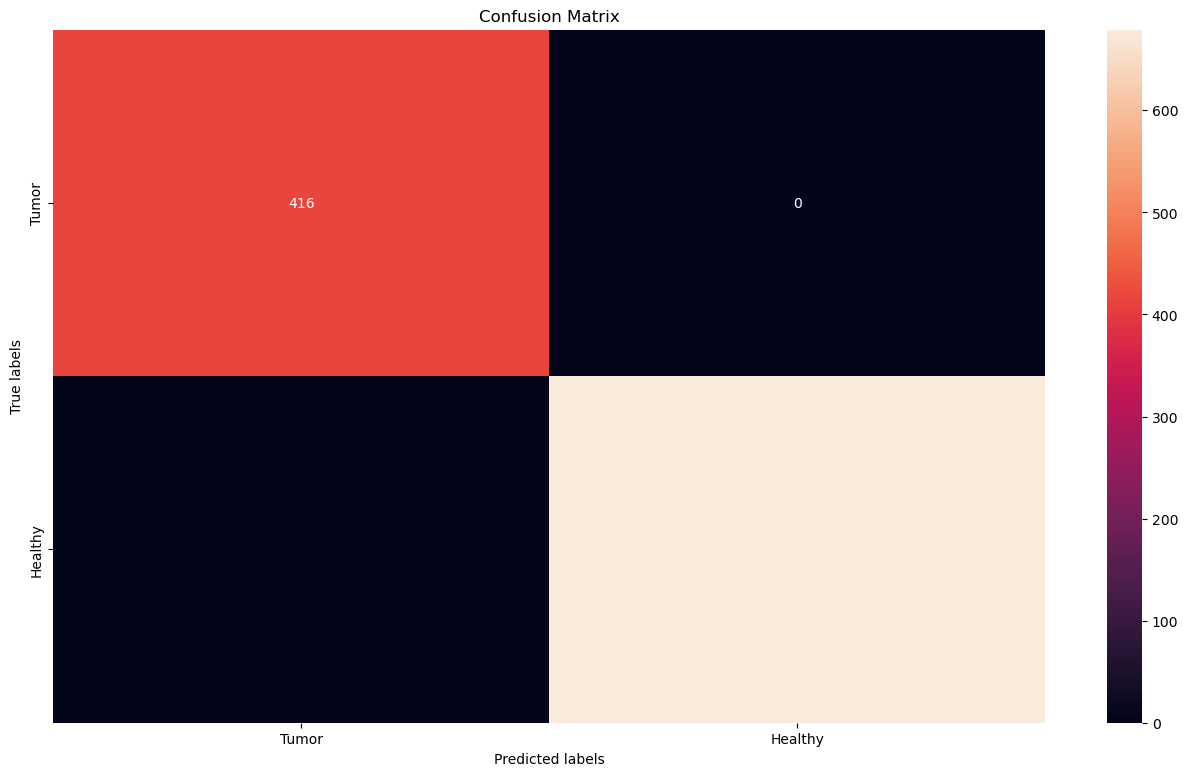

In [27]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  



ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

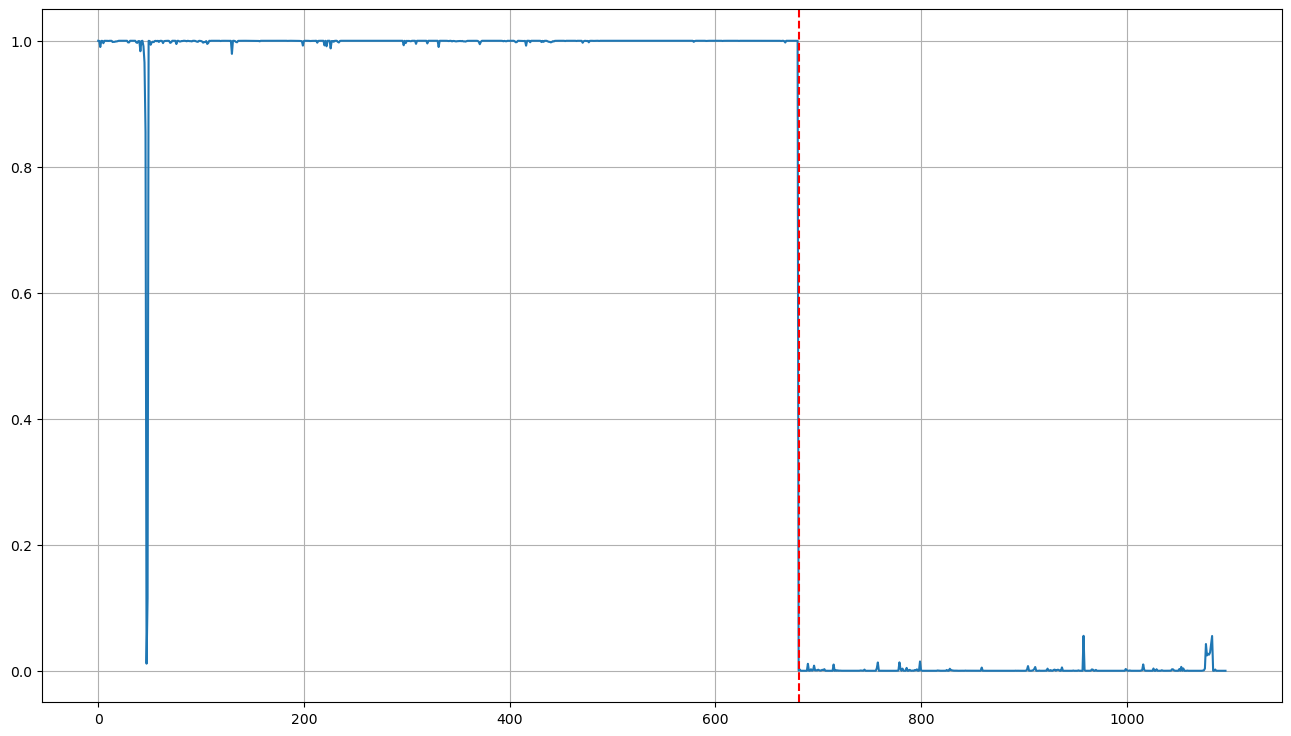

In [28]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [29]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [30]:
no_of_layers = 0
conv_layers = []

In [31]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [32]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [33]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

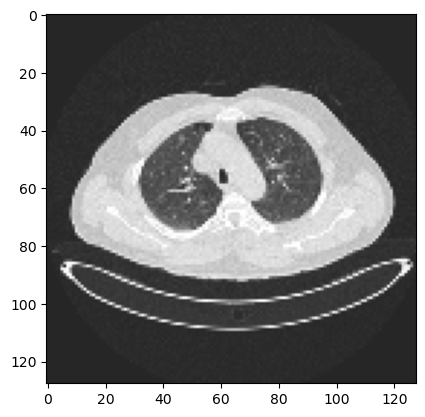

In [34]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [35]:
img = torch.from_numpy(img).to(device)

In [36]:
img.shape

torch.Size([3, 128, 128])

In [37]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [38]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


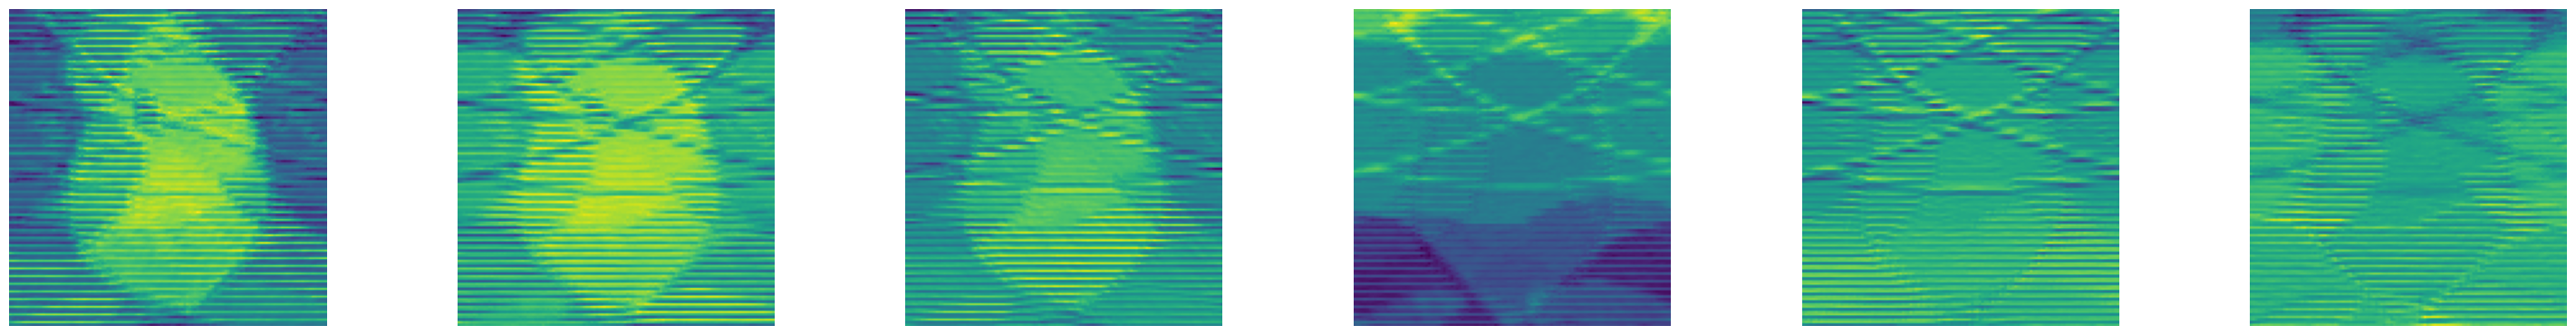

Layer  2


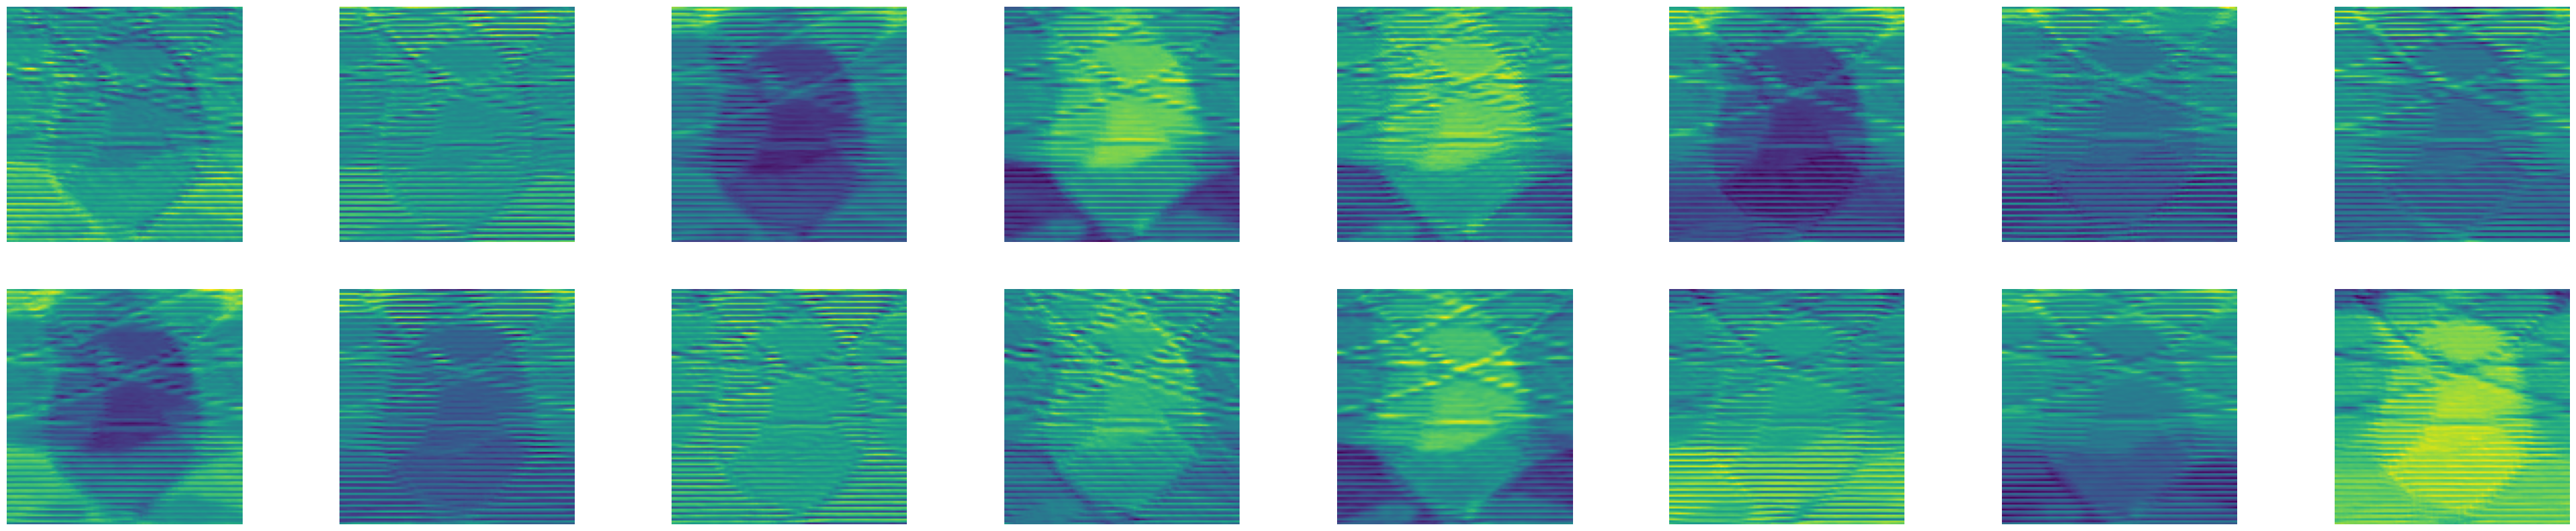

In [39]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

In [40]:

from sklearn.model_selection import train_test_split

In [41]:
class MRI(Dataset):
    
    def __init__(self):
        
        
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        
        
        self.mode = 'train'
        
        tumor = []
        healthy = []
       
        for f in glob.iglob('./data/lungcancer_dataset/NormalCases/*.jpg'):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) 
            tumor.append(img)

        for f in glob.iglob('./data/lungcancer_dataset/NormalCases/*.jpg'):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
       
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
        
    def __len__(self):
        
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, idx):
        
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [42]:
from torchvision import transforms



train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



In [43]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [44]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

In [45]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [46]:

epoch_train_loss = []
epoch_val_loss = []

In [47]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_


scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)


for epoch in range(1, 400):
    train_losses = []
    
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
       
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        
        
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    
    val_losses = []
    model.eval()
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    
    scheduler.step(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses), np.mean(val_losses)))


C:\Users\User\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Train Epoch: 10	Train Loss: 0.588967	Val Loss: 0.586884
Train Epoch: 20	Train Loss: 0.466149	Val Loss: 0.456858
Train Epoch: 30	Train Loss: 0.337829	Val Loss: 0.330006
Train Epoch: 40	Train Loss: 0.265008	Val Loss: 0.256323
Train Epoch: 50	Train Loss: 0.215137	Val Loss: 0.223575
Train Epoch: 60	Train Loss: 0.167126	Val Loss: 0.156203
Train Epoch: 70	Train Loss: 0.149545	Val Loss: 0.123126
Train Epoch: 80	Train Loss: 0.099455	Val Loss: 0.093446
Train Epoch: 90	Train Loss: 0.076602	Val Loss: 0.066718
Train Epoch: 100	Train Loss: 0.060638	Val Loss: 0.049584
Train Epoch: 110	Train Loss: 0.045700	Val Loss: 0.039938
Train Epoch: 120	Train Loss: 0.038772	Val Loss: 0.047240
Train Epoch: 130	Train Loss: 0.027783	Val Loss: 0.022246
Train Epoch: 140	Train Loss: 0.021210	Val Loss: 0.020798
Train Epoch: 150	Train Loss: 0.020962	Val Loss: 0.019776
Train Epoch: 160	Train Loss: 0.012846	Val Loss: 0.012689
Train Epoch: 170	Train Loss: 0.012602	Val Loss: 0.011898
Train Epoch: 180	Train Loss: 0.012321	Va

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

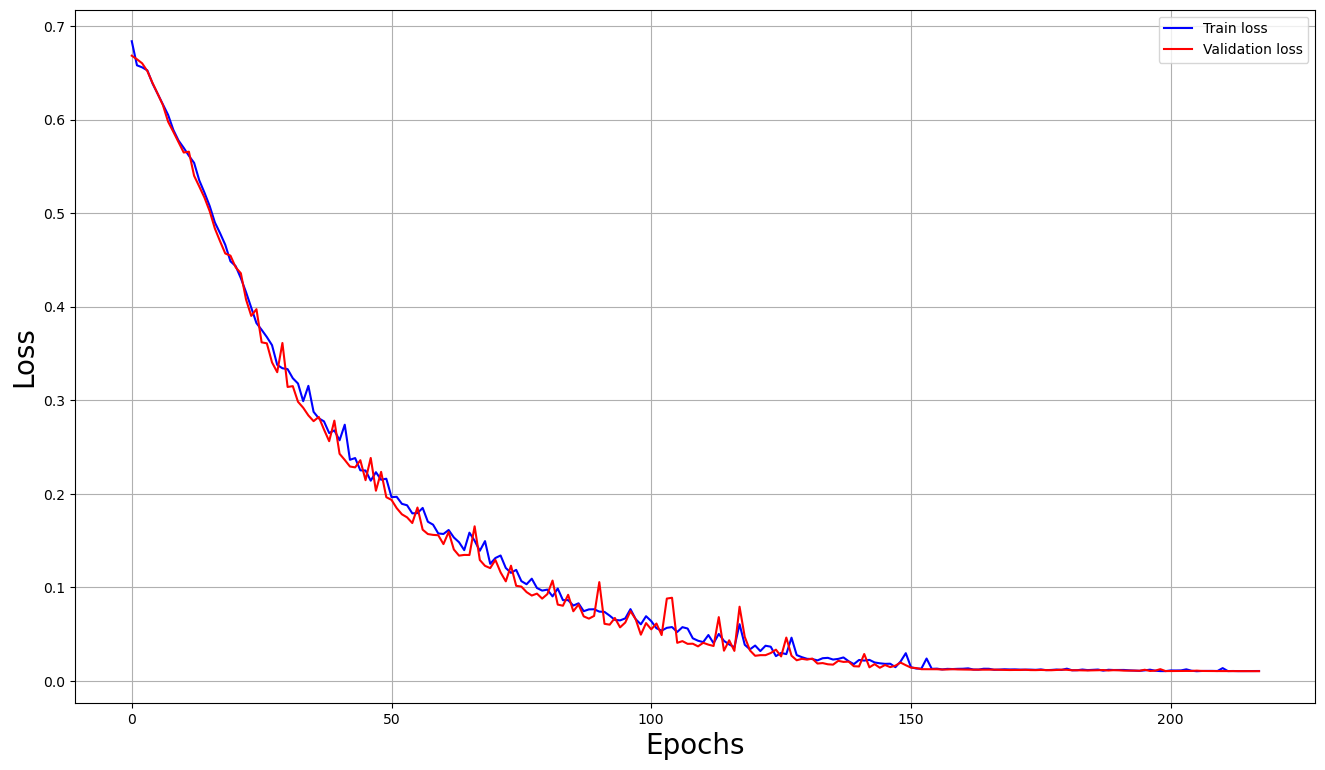

In [48]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


train_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []

val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

for epoch in range(1, EPOCH):
    losses = []
    predictions = []
    targets = []
    for D in train_dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
       
        error = nn.BCELoss() 
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        
        predictions.extend(torch.round(y_hat).cpu().detach().numpy())
        targets.extend(label.cpu().detach().numpy())
        
    
    train_accuracy = accuracy_score(targets, predictions)
    train_precision = precision_score(targets, predictions)
    train_recall = recall_score(targets, predictions)
    train_f1 = f1_score(targets, predictions)
    
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1)
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}\tAccuracy: {:.6f}\tPrecision: {:.6f}\tRecall: {:.6f}\tF1-score: {:.6f}'.format(epoch+1, np.mean(losses), train_accuracy, train_precision, train_recall, train_f1))


Train Epoch: 10	Loss: 0.020402	Accuracy: 0.996354	Precision: 0.997063	Recall: 0.997063	F1-score: 0.997063
Train Epoch: 20	Loss: 0.009706	Accuracy: 0.996354	Precision: 0.997063	Recall: 0.997063	F1-score: 0.997063
Train Epoch: 30	Loss: 0.009485	Accuracy: 0.997265	Precision: 0.998529	Recall: 0.997063	F1-score: 0.997796
Train Epoch: 40	Loss: 0.009254	Accuracy: 0.997265	Precision: 0.998529	Recall: 0.997063	F1-score: 0.997796
Train Epoch: 50	Loss: 0.009134	Accuracy: 0.997265	Precision: 0.998529	Recall: 0.997063	F1-score: 0.997796
Train Epoch: 60	Loss: 0.008946	Accuracy: 0.997265	Precision: 0.998529	Recall: 0.997063	F1-score: 0.997796
Train Epoch: 70	Loss: 0.008879	Accuracy: 0.997265	Precision: 0.998529	Recall: 0.997063	F1-score: 0.997796
Train Epoch: 80	Loss: 0.008694	Accuracy: 0.997265	Precision: 0.998529	Recall: 0.997063	F1-score: 0.997796
Train Epoch: 90	Loss: 0.008596	Accuracy: 0.997265	Precision: 0.998529	Recall: 0.997063	F1-score: 0.997796
Train Epoch: 100	Loss: 0.008527	Accuracy: 0.99

KeyboardInterrupt: 

In [50]:

overall_train_accuracy = np.mean(train_accuracies)
overall_train_precision = np.mean(train_precisions)
overall_train_recall = np.mean(train_recalls)
overall_train_f1 = np.mean(train_f1_scores)

print("Overall Training Performance:")
print("Accuracy: {:.6f}".format(overall_train_accuracy))
print("Precision: {:.6f}".format(overall_train_precision))
print("Recall: {:.6f}".format(overall_train_recall))
print("F1-score: {:.6f}".format(overall_train_f1))


Overall Training Performance:
Accuracy: 0.997670
Precision: 0.998830
Recall: 0.997417
F1-score: 0.998123


In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


test_accuracies = []
test_precisions = []
test_recalls = []
test_f1_scores = []

for epoch in range(1, 400): 
    model.eval()  
    test_losses = []
    test_predictions = []
    test_targets = []
    
    with torch.no_grad():  
        for D in test_dataloader:  
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)

            
            y_hat = y_hat.view_as(label)

            error = nn.BCELoss()
            loss = error(y_hat, label)  
            test_losses.append(loss.item())
            
          
            test_predictions.extend(torch.round(y_hat).cpu().detach().numpy())
            test_targets.extend(label.cpu().detach().numpy())
    
    
    test_accuracy = accuracy_score(test_targets, test_predictions)
    test_precision = precision_score(test_targets, test_predictions)
    test_recall = recall_score(test_targets, test_predictions)
    test_f1 = f1_score(test_targets, test_predictions)
    
    test_accuracies.append(test_accuracy)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_f1_scores.append(test_f1)
    
    
    if (epoch + 1) % 10 == 0:
        print(f'Test Epoch: {epoch+1}\tLoss: {np.mean(test_losses):.6f}\tAccuracy: {test_accuracy:.6f}\tPrecision: {test_precision:.6f}\tRecall: {test_recall:.6f}\tF1-score: {test_f1:.6f}')


Test Epoch: 10	Loss: 0.004733	Accuracy: 1.000000	Precision: 1.000000	Recall: 1.000000	F1-score: 1.000000
Test Epoch: 20	Loss: 0.004733	Accuracy: 1.000000	Precision: 1.000000	Recall: 1.000000	F1-score: 1.000000
Test Epoch: 30	Loss: 0.004733	Accuracy: 1.000000	Precision: 1.000000	Recall: 1.000000	F1-score: 1.000000
Test Epoch: 40	Loss: 0.004733	Accuracy: 1.000000	Precision: 1.000000	Recall: 1.000000	F1-score: 1.000000
Test Epoch: 50	Loss: 0.004733	Accuracy: 1.000000	Precision: 1.000000	Recall: 1.000000	F1-score: 1.000000
Test Epoch: 60	Loss: 0.004733	Accuracy: 1.000000	Precision: 1.000000	Recall: 1.000000	F1-score: 1.000000
Test Epoch: 70	Loss: 0.004733	Accuracy: 1.000000	Precision: 1.000000	Recall: 1.000000	F1-score: 1.000000
Test Epoch: 80	Loss: 0.004733	Accuracy: 1.000000	Precision: 1.000000	Recall: 1.000000	F1-score: 1.000000
Test Epoch: 90	Loss: 0.004733	Accuracy: 1.000000	Precision: 1.000000	Recall: 1.000000	F1-score: 1.000000
Test Epoch: 100	Loss: 0.004733	Accuracy: 1.000000	Preci

KeyboardInterrupt: 

In [52]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_


scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1)

test_losses = [] 

for epoch in range(1, 400):
    model.eval()  
    test_epoch_losses = []
    
    with torch.no_grad():  
        for D in test_dataloader:
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)

           
            y_hat = y_hat.view_as(label)

            error = nn.BCELoss()
            loss = error(y_hat, label)  
            test_epoch_losses.append(loss.item())
    
    
    test_loss = np.mean(test_epoch_losses)
    test_losses.append(test_loss)

    
    model.eval()  
    val_losses = []
    
    with torch.no_grad():
        for D in val_dataloader:
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            
            
            y_hat = y_hat.view_as(label)
            
            error = nn.BCELoss()
            loss = error(y_hat, label) 
            val_losses.append(loss.item())
    
    val_loss = np.mean(val_losses)
    
    
    scheduler.step(val_loss)
    
    if (epoch + 1) % 10 == 0:
        
        last_lr = scheduler.optimizer.param_groups[0]['lr']
        print('Epoch: {}\tTest Loss: {:.6f}\tValidation Loss: {:.6f}\tLast LR: {:.8f}'.format(epoch+1, test_loss, val_loss, last_lr))


Epoch: 10	Test Loss: 0.004733	Validation Loss: 0.008062	Last LR: 0.00000010
Epoch: 20	Test Loss: 0.004733	Validation Loss: 0.008062	Last LR: 0.00000001
Epoch: 30	Test Loss: 0.004733	Validation Loss: 0.008062	Last LR: 0.00000001
Epoch: 40	Test Loss: 0.004733	Validation Loss: 0.008062	Last LR: 0.00000001
Epoch: 50	Test Loss: 0.004733	Validation Loss: 0.008062	Last LR: 0.00000001
Epoch: 60	Test Loss: 0.004733	Validation Loss: 0.008062	Last LR: 0.00000001
Epoch: 70	Test Loss: 0.004733	Validation Loss: 0.008062	Last LR: 0.00000001
Epoch: 80	Test Loss: 0.004733	Validation Loss: 0.008062	Last LR: 0.00000001
Epoch: 90	Test Loss: 0.004733	Validation Loss: 0.008062	Last LR: 0.00000001
Epoch: 100	Test Loss: 0.004733	Validation Loss: 0.008062	Last LR: 0.00000001
Epoch: 110	Test Loss: 0.004733	Validation Loss: 0.008062	Last LR: 0.00000001
Epoch: 120	Test Loss: 0.004733	Validation Loss: 0.008062	Last LR: 0.00000001
Epoch: 130	Test Loss: 0.004733	Validation Loss: 0.008062	Last LR: 0.00000001
Epoch: 1

KeyboardInterrupt: 

In [53]:

overall_test_accuracy = np.mean(test_accuracies)
overall_test_precision = np.mean(test_precisions)
overall_test_recall = np.mean(test_recalls)
overall_test_f1 = np.mean(test_f1_scores)

print("Overall Testing Performance:")
print("Accuracy: {:.6f}".format(overall_test_accuracy))
print("Precision: {:.6f}".format(overall_test_precision))
print("Recall: {:.6f}".format(overall_test_recall))
print("F1-score: {:.6f}".format(overall_test_f1))


Overall Testing Performance:
Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1-score: 1.000000
